## Credits and References
The code is adapted from the binary classification example as given in the segmentation_models package https://github.com/qubvel/segmentation_models.<br><br>

The structure of the code mainly relies on two packages- segmentation-models and albumentations (available to install using pip).<br><br>
We use Keras module integrated inside TensorFlow to build the CNN.<br><br>

The notebook is inspired by ZeroCostDL4Mic (https://github.com/HenriquesLab/ZeroCostDL4Mic).

### Note: If you want to run only the inference using a pre-trained model -
1. Run steps 0, 1, 2 and 3
2. Jump to the last step

# **0. Getting started with this notebook**
---
This notebook contains two types of cell: text and code.

*   **Text** cells are formatted using a simple markup language called Markdown. They can be created by clickin on  ``` + text ``` 
*   **Code** cells contain either explanatory text or executable code and its output. They can be created by clickin on  ``` + code ```  

To execute or run the **Code** cell, click on the play button on the left side of the cell.<br>
Double clicking on any cell will toggle the edit and display modes.

For more information about these type of cells you can click [here](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 

# **1. Getting Set Up**
---

In [ ]:
#@markdown ## Mount the Google drive
#@markdown Once mounted, your files can be browsed on the left hand side panel.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown ##Set up the IPython notebook

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show/Hide code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [ ]:
#@markdown ##Install segmentation-models package

!pip install segmentation-models

In [ ]:
#@markdown ##Install albumentations package

!pip install -U albumentations

In [ ]:
#@markdown ##Set tensorflow's keras module as the framework for the package segmentation-models
#@markdown This needs to be done to be able to use segmentation-models with tensorflow-2.4.<br>
#@markdown See code to know more.
# There is a known problem with efficientnet code and segementation-models code when using keras framework.
# This problem is not there for the tensorflow.keras backend.
# Set this environment variable to tf.keras so that segmentation-model does not give error by loading keras framework by default.
# Otherwise use tensorflow 1.x (2.1 might also work).
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
#@markdown ##Import packages and check versions

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import albumentations as A
from sklearn.model_selection import train_test_split
import tifffile

# Optional: Choose tensorflow version
#%tensorflow_version 2.x

# Check versions
print("Tensorflow", tf.__version__)
print("Albumentations", A.__version__)
print("segmentation-models", sm.__version__)

sm.set_framework('tf.keras')
sm.framework()
hide_toggle()

Segmentation Models: using `tf.keras` framework.
Tensorflow 2.11.0
Albumentations 1.3.0
segmentation-models 1.0.1


# **2. Settings for the Colab session**
---


##Confirm the GPU access

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:
For more information click [here](https://cloud.google.com/gpu)

In [ ]:
#@markdown # Make sure the GPU is available
# Make sure the GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
hide_toggle()

Found GPU at: /device:GPU:0


# **3.  Set up data pipelines and visualization methods**

#### This section defines data loader and augmentation functions which are necessary for both training and inference.
#### Hence, if you only want to run the inference using a model trained before, you will still need to run these cells.
---

In [ ]:
#@markdown ### Define data loader and visualization functions

# helper function for data visualization
def visualize(cmap="gray", **images):
    #PLot images in one row
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=cmap)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    #Scale image to range [0,1] for correct plot
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """ This class is adapted from the binary classification examples in the segmentation_models repository.
    """
    
    def __init__(
            self,
            images_dir=None,
            images_filelist=None,
            masks_dir=None,
            #classes=None,
            class_value_pairs=None,
            augmentation=None,
            preprocessing=None,
            erode=False
    ):
        
        self.ids = images_filelist
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        if masks_dir:
          self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
          #print(len(self.images_fps), len(self.masks_fps))
        else:
          self.masks_fps = None

        self.classes = []
        self.class_values = []
        for classname in sorted(class_value_pairs.keys()):
          self.classes.append(classname)
          
          #self.class_values.append(class_value_pairs[classname])
          # if class has more than one values, do the following-
          for val in class_value_pairs[classname]:
            self.class_values.append(val)

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.erode = erode
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #print(self.images_fps[i])
        #print(image.shape)

        # Process masks
        if self.masks_fps:
          mask = cv2.imread(self.masks_fps[i], 0)
          #print(self.masks_fps[i])

          # extract certain classes from mask (e.g. cars)
          masks = [(mask == v) for v in self.class_values]
          mask = np.stack(masks, axis=-1).astype(float)
          
          # Create background from mask
          # Then invert the background to get
          # mask of all segment values
          #if mask.shape[-1] != 1: # Not necessary any more
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)
          mask = 1 - background
          
          # apply augmentations
          if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
          
          # apply preprocessing
          if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


          # Optional: apply erosion to the mask
          if self.erode:
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.erode(mask, kernel, iterations=1)
            mask = np.expand_dims(mask, 2)

          #print(np.unique(mask), mask.shape, image.shape)# [0.0 255.0]

          return (image, mask)

        else:

          # apply augmentations
          if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

          # apply preprocessing
          if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']


          #if self.crop

          return (image,)
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(tf.keras.utils.Sequence):
    """This class is adapted from the binary classification examples in the segmentation_models repository.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        # Returns the number of batches per epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        # Shuffle indices on each epoch
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
hide_toggle()

In [ ]:
#@markdown ### Define augmentation functions

# These functions are adapted from the binary classification examples in the segmentation_models repository.

import warnings
warnings.filterwarnings('ignore')

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

#Stretching

def get_validation_augmentation():
    # Add paddings to make image shape divisible by 32
    test_transform = [
        #A.PadIfNeeded(384, 480)
        #A.PadIfNeeded(320, 320),
        #A.RandomCrop(height=320, width=320, always_apply=True),
        A.Resize(320, 320, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    # Build preprocessing transform
        
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

hide_toggle()

# **4. Input and pre-processing**
---

### Set path to training images
A set of training images along with corresponding segmentation masks are used to train the model to determine segmentation masks for new images. Both images_dir and masks_dir should contain same number of corresponding images.


In [ ]:
# ------------- Initial user input ------------
images_dir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/em" #@param {type:"string"}
masks_dir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/seg_eroded"#@param {type:"string"}
hide_toggle()

In [ ]:
#@markdown Create sorted file lists from the input image and mask folders<br>

images_filelist = sorted(os.listdir(images_dir))
masks_filelist = sorted(os.listdir(masks_dir))

print("Number of images:", len(images_filelist))
print("Number of masks:", len(masks_filelist))

assert(len(images_filelist) == len(masks_filelist))

hide_toggle()

Number of images: 85
Number of masks: 85


img_s1450.png


True

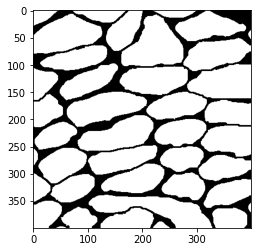

In [ ]:
#@markdown See sample mask (and optionally save to file, view code to edit)
fname = masks_filelist[80]
print(fname)
img = cv2.imread(masks_dir + "/" + fname, 0)
img = img>0
img = img*255

plt.imshow(img, cmap='gray')

# Optional- save image to file
# IMPORTANT: CONFIRM THAT THIS FOLDER IS NOT SAME AS THE masks_dir folder. OTHERWISE THE ORIGINAL MASK WILL BE OVERWRITTEN.
#outdir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/seg_eroded_bw_examples"
#cv2.imwrite(outdir + "/" + fname, img)

### Split the dataset in train, test and validation sets

The input images are split in three sets. The train set is used to train the model. Validation set is used to evaluate the model performance during training stage. The test set is kept aside for an additional independent evaluation of the stored model.<br>

The fractions of test and validation sets can be given in ``` Test_fraction ``` and ``` Validation_fraction ```.<br>
In order to randomize the selection you can use a ``` random_seed ```.

In [ ]:
#@markdown Create Train, Validation and Test sets

Test_data=0.1 #@param{type:"number"}
Validation_data=0.2 #@param{type:"number"}
random_seed=42 #@param{type:"number"}

# Split training images into train and validation filelists
images_filelist = sorted(os.listdir(images_dir))
masks_filelist = sorted(os.listdir(masks_dir))

train_images_filelist, test_images_filelist, train_masks_filelist, test_masks_filelist = train_test_split(images_filelist, masks_filelist, test_size=Test_data, random_state=random_seed)

train_images_filelist, val_images_filelist, train_masks_filelist, val_masks_filelist = train_test_split(train_images_filelist, train_masks_filelist, test_size=Validation_data, random_state=random_seed)

print("Train images:", len(train_images_filelist), ", Validation images:", len(val_images_filelist), ", Test images:", len(test_images_filelist))
print("Train masks:", len(train_masks_filelist), ", Validation masks:", len(val_masks_filelist), ", Test masks:", len(test_masks_filelist))

hide_toggle()

Train images: 60 , Validation images: 16 , Test images: 9
Train masks: 60 , Validation masks: 16 , Test masks: 9


> ### Define what to read from masks<br>
The ```Segment_name``` can be any name which you want to give to your segmented object.<br>
The ```Segment_value``` should be the intensity value corresponding to that segment. You can choose any non-zero value from the mask's unique values. Or you can also provide multiple comma separated values. See the next cell.<br>
Please note that a wrong segment value (which is not there in the mask) will lead to a blank mask.

In [ ]:
#@markdown ### Check unique values in the masks

v = []
cnt = 0
for fname in masks_filelist:
  m = cv2.imread(masks_dir+"/"+fname, 0)
  #print(fname)
  #print(np.unique(m))
  v += list(np.unique(m))
  #print(cnt, v)
  cnt += 1

print('\nMask unique values:', ", ".join([str(x) for x in np.unique(np.array(v))]))



Mask unique values: 0, 5, 8, 9, 10, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 62, 64, 66, 67, 71, 72, 73, 75, 78, 80, 81, 82, 84, 85, 86, 89, 90


In [ ]:
#@markdown ### Define the segment label to read
#@markdown Use a one or more **NON-ZERO** values from above as ```Segment_value```.<br>
#@markdown Multiple values must be comma separated.

Segment_name='cell' #@param {type:"string"}

Segment_value='5, 8, 9, 10, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 62, 64, 66, 67, 71, 72, 73, 75, 78, 80, 81, 82, 84, 85, 86, 89, 90' #@param {type:"string"}

Segment_value = [int(v) for v in Segment_value.split(",")]

print("Number of segment values set:", len(Segment_value))
print("These", len(Segment_value), "segment values will be merged during further processes.")

Number of segment values set: 58
These 58 segment values will be merged during further processes.


Image shape: (400, 400, 3)   Mask shape: (400, 400, 1) Image min, max: 223 , 223


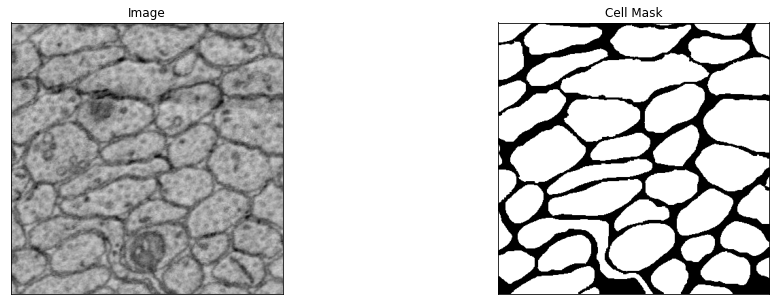

In [ ]:
#@markdown ### Load data and visualize (without augmentation)<br>
#@markdown If you see a correct image-mask pair after running this cell, then the dataset is loaded correctly.
# helper function for data visualization

# Showing images from dataset
dataset = Dataset(images_dir=images_dir,
                  images_filelist=train_images_filelist, 
                  masks_dir=masks_dir,
                  class_value_pairs={Segment_name:Segment_value},
                  erode=False)

image, mask = dataset[2] # get some sample
print("Image shape:", image.shape, "  Mask shape:", mask.shape, "Image min, max:", image.max(),",",image.max())

visualize(cmap="gray",
    image=image,
    cell_mask=mask[..., 0].squeeze()
    #background_mask=mask[..., 2].squeeze()
)
hide_toggle()

Image shape: (320, 320, 3)   Mask shape: (320, 320, 1) Image min, max: 0 , 229


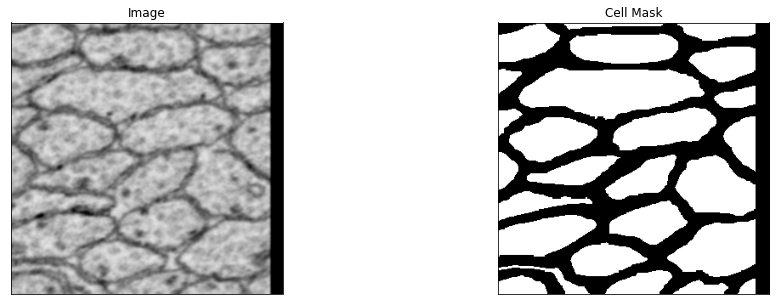

In [ ]:
#@markdown ### Load data and visualize (with augmentation)
#@markdown If you see a correct image-mask pair after running this cell, then the dataset is loaded correctly.

dataset = Dataset(images_dir=images_dir,
                  images_filelist=train_images_filelist,
                  masks_dir=masks_dir,
                  class_value_pairs={Segment_name:Segment_value},
                  augmentation=get_training_augmentation(),
                  erode=True)

image, mask = dataset[17] # get some sample
print("Image shape:", image.shape, "  Mask shape:", mask.shape, "Image min, max:", image.min(),",",image.max())
visualize(cmap="gray",
    image=image, 
    cell_mask=mask[..., 0].squeeze()
    #background_mask=mask[..., 2].squeeze()
)
hide_toggle()

# **5. Define U-net parameters**
---



*   **ENCODER_WEIGHTS** – None (for random initialization), imagenet (for pre-training on ImageNet). Using ImageNet weights to start the training process may result in faster training.
*   **BACKBONE** – name of classification model to be used as feature extractor to build segmentation model. Last dense layers are not considered.<br>
You can use any of the following backbones.<br>
VGG: ``vgg16``, ``vgg19``<br>
ResNet: ``resnet18``, ``resnet34``, ``resnet50``, ``resnet101``, ``resnet152``<br>
SE-ResNet: ``seresnet18``, ``seresnet34``, ``seresnet50``, ``seresnet101``, ``seresnet152``<br>
ResNeXt: ``resnext50``, ``resnext101``<br>
SE-ResNeXt: ``seresnext50``, ``seresnext101``<br>
SENet154: ``senet154``<br>
DenseNet: ``densenet121``, ``densenet169``, ``densenet201``<br>
Inception: ``inceptionv3``, ``inceptionresnetv2``<br>
MobileNet: ``mobilenet``, ``mobilenetv2``<br>
EfficientNet: ``efficientnetb0``, ``efficientnetb1``, ``efficientnetb2``, ``efficientnetb3``, ``efficientnetb4``, ``efficientnetb5``, ``efficientnetb6``, ``efficientnetb7``<br>
Please refer to https://github.com/qubvel/segmentation_models for more details.

*   **BATCH_SIZE** - The number of samples that will be used by the network to at in a single step. Larger batch sizes generalize better in general. However, batch size can also be very small, for example- 2, if the number of training samples is small.
*   **LEARNING RATE (LR)** - Factor to control how much the model weights are updated to account for the estimated error. Faster learning rates (higher value) result in faster training process but may produce unstable results or poor learning. Slower learning rates (lower value) can make the training process very slow, sometimes not reaching the optimum in reasonable time.
*   **EPOCHS** - The number of epochs is the number of times the training happens on the full training dataset.


In [ ]:
#@markdown ### Set parameters<br>
#@markdown Note that the Segment_name and Segment_value are the same parameters which we tested before for verification of the dataset creation.

ENCODER_WEIGHTS = 'imagenet' #@param {type:"string"}
BACKBONE = 'inceptionresnetv2'  #@param {type:"string"}
BATCH_SIZE = 2 #@param {type:"number"}

Segment_name = 'cell' #@param {type:"string"}
Segment_value = '5, 8, 9, 10, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 62, 64, 66, 67, 71, 72, 73, 75, 78, 80, 81, 82, 84, 85, 86, 89, 90' #@param {type:"string"}
Segment_value = [int(v) for v in Segment_value.split(",")]

class_value_pairs={Segment_name:Segment_value}
CLASSES = list(class_value_pairs.keys())
LR = 0.0001 #@param {type:"number"}
EPOCHS = 30 #@param {type:"number"}

# Needed for data loader
preprocess_input = sm.get_preprocessing(BACKBONE)

print("Number of segment values set:", len(Segment_value))
print("These", len(Segment_value), "segment values will be merged during further processes.")
print("REMINDER: Use the same segment values which you tested in one of the previous code blocks.")

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

Number of segment values set: 60
These 60 segment values will be merged during further processes.
REMINDER: Use the same segment values which you tested in one of the previous code blocks.


# **6. Create model**
---

In [ ]:
#@markdown ### Create a UNET model using the parameters defined above
model = sm.Unet(BACKBONE,
                classes=n_classes,
                encoder_weights=ENCODER_WEIGHTS,
                activation=activation)

219055592/219055592 [==============================] - 59s 0us/step


In [ ]:
#@markdown ### Define optimizer

optim = tf.keras.optimizers.Adam(LR)
print("Optimizer:", optim)

Optimizer: <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7febc0748430>


In [ ]:
#@markdown ### Define segmentation models losses
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
print("Loss:", total_loss)

Loss: <segmentation_models.base.objects.SumOfLosses object at 0x7feb6211dc70>


In [ ]:
#@markdown ### Compile the model
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)
print("Model compiled.")

Model compiled.


# **7. Setup datasets and output directories**
---

In [ ]:
#@markdown ### Define training and validation datasets

# Dataset for train images
train_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=train_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={Segment_name:Segment_value},
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataset for validation images
valid_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=val_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={Segment_name:Segment_value},
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

print("Training dataset:", len(train_dataloader.indexes), "files.")
print("Validation dataset:", len(valid_dataloader.indexes), "files.")

hide_toggle()

Training dataset: 60 files.
Validation dataset: 16 files.


In [ ]:
#@markdown  ### Define output folder for trained model and set up model callbacks for learning rate scheduling and best checkpoints saving
models_dir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/unet_output" #@param {type:"string"}
name_CNN =  '/model_inceptionresnetv2_new_trial.h5' #@param {type:"string"}
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(models_dir+name_CNN,
                                       save_weights_only=True,
                                       save_best_only=True,
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

# **8. Train the model**
---

In [ ]:
#@markdown ### Train the model (This may take a long time)

history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

Epoch 1/30
30/30 [==============================] - 167s 2s/step - loss: 0.4943 - iou_score: 0.4442 - f1-score: 0.5989 - val_loss: 0.5820 - val_iou_score: 0.1202 - val_f1-score: 0.2139 - lr: 1.0000e-04
Epoch 2/30
30/30 [==============================] - 21s 705ms/step - loss: 0.3658 - iou_score: 0.7211 - f1-score: 0.8368 - val_loss: 0.4329 - val_iou_score: 0.5705 - val_f1-score: 0.7254 - lr: 1.0000e-04
Epoch 3/30
30/30 [==============================] - 17s 559ms/step - loss: 0.3040 - iou_score: 0.7712 - f1-score: 0.8694 - val_loss: 0.3504 - val_iou_score: 0.7800 - val_f1-score: 0.8762 - lr: 1.0000e-04
Epoch 4/30
30/30 [==============================] - 22s 728ms/step - loss: 0.2682 - iou_score: 0.7929 - f1-score: 0.8835 - val_loss: 0.2822 - val_iou_score: 0.8221 - val_f1-score: 0.9022 - lr: 1.0000e-04
Epoch 5/30
30/30 [==============================] - 15s 493ms/step - loss: 0.2435 - iou_score: 0.8107 - f1-score: 0.8946 - val_loss: 0.2507 - val_iou_score: 0.8374 - val_f1-score: 0.9113

# **9. Plot results**
---

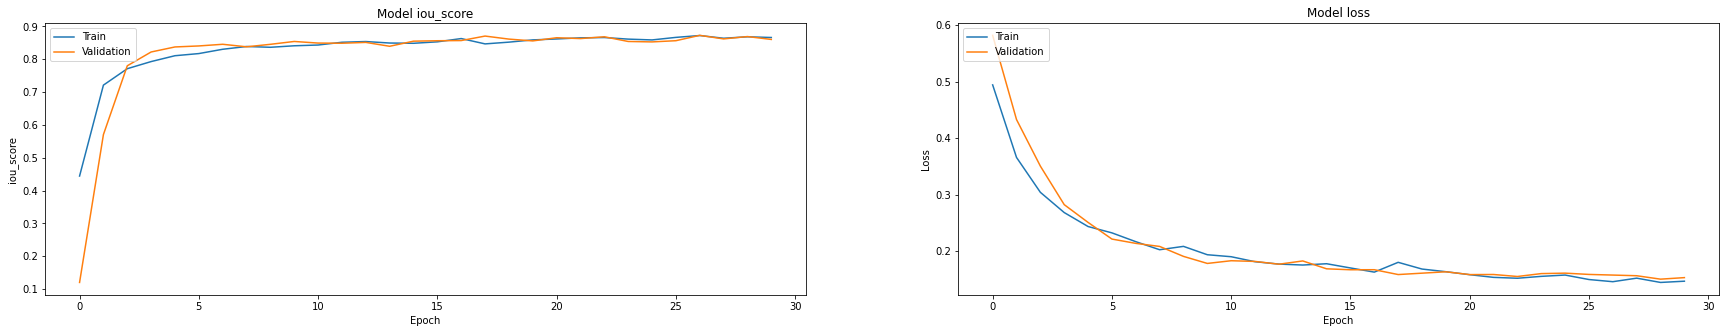

In [ ]:
#@markdown Plot 1: train and validation iou_score values (iou: Intesection over Union)<br>
#@markdown Plot 2: Plot train and validation loss values
#@markdown Gradual lowering of values for further epochs may suggest that the training process is proceeding correctly.<br>
#@markdown Sudden jumps in the iou scores or the loss values may indicate unstable learning.

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
 
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plt.savefig(models_dir + "/" + name_CNN.replace("/","").replace(".h5","") + "_training_performance.png")

hide_toggle()

# **10. Model Evaluation (Testing)**
---

In [ ]:
#@markdown ### Load test dataset

Segment_name='cell' #@param {type:"string"}

Segment_value = '5, 8, 9, 10, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 62, 64, 66, 67, 71, 72, 73, 75, 78, 80, 81, 82, 84, 85, 86, 89, 90' #@param {type:"string"}

print("Number of samples in test dataset:", len(test_images_filelist))

Segment_value = [int(v) for v in Segment_value.split(",")]

print("Number of segment values set:", len(Segment_value))
print("These", len(Segment_value), "segment values will be merged during further processes.")
print("REMINDER: Use the same segment values which you tested in one of the previous code blocks.")

test_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=test_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={Segment_name:Segment_value},
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

"""
# Optional visualize to confirm that the correct dataset is loaded.
image, mask = test_dataset[0] # get some sample
print("Image shape:", image.shape, "  Mask shape:", mask.shape, "Image min, max:", image.min(),",",image.max())
visualize(cmap="gray",
    image=image, 
    cell_mask=mask[..., 0].squeeze()
    #background_mask=mask[..., 2].squeeze()
)
"""

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)


Number of samples in test dataset: 9
Number of segment values set: 60
These 60 segment values will be merged during further processes.
REMINDER: Use the same segment values which you tested in one of the previous code blocks.


In [ ]:
#@markdown ### Load best weights from the saved model and evaluate on the test dataset<br>
#@markdown You only have to give the path to the saved model (for example, the '.h5' file in a previous step).

best_weights= '/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/unet_output/model_inceptionresnetv2.h5'#@param {type:"string"}
model.load_weights(best_weights)

print("Model evaluation:")
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
    
hide_toggle()

Model evaluation:
9/9 [==============================] - 6s 751ms/step - loss: 0.1435 - iou_score: 0.8746 - f1-score: 0.9331
Loss: 0.14352
mean iou_score: 0.87465
mean f1-score: 0.93307


In [ ]:
#@markdown ### Visualize test results for random samples from test dataset
#@markdown Image: Original image, Gt Mask: Groundtruth Mask, Pr Mask: Predicted Mask

num_samples = 3 #@param {type:"number"}

ids = np.random.choice(np.arange(len(test_dataset)), size=num_samples)

for i in ids:
  image, gt_mask = test_dataset[i]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  print("Image shape:", image.shape, "  Mask shape:", mask.shape, "Image min, max:", image.max(),",",image.max())
  visualize(cmap="gray",
            image=image[0][:,:,0],
            gt_mask=gt_mask[..., 0].squeeze(),
            pr_mask=pr_mask[..., 0].squeeze()
            #background_mask=mask[..., 2].squeeze()
            )

hide_toggle()

# **11. Inference**
---

### Predict on new images and save predicted masks  
You can directly jump to this step if you already have a trained model.
The only prerequisite is to compile the same model architecture before loading weights from the stored model.<br>
To do this, please use the same settings as those used before the training step and compile the model.<br>
After this, you can load the stored model.

In [ ]:
#@markdown ### Set parameters<br>
#@markdown Note that the Segment_name and Segment_value are the same parameters which we tested before for verification of the dataset creation.

BACKBONE = 'inceptionresnetv2'  #@param {type:"string"}
#@markdown **Segment_name** can be any text.<br> 
#@markdown Keep **Segment_value** field empty.

# This is necessary for the the data loader
Segment_name = 'cell' #@param {type:"string"}
Segment_value = '' #@param {type:"string"}
preprocess_input = sm.get_preprocessing(BACKBONE)

if Segment_value.strip() != '':
  Segment_value = [int(v) for v in Segment_value.split(",")]
else:
  Segment_value = []


In [ ]:
#@markdown ### Create a UNET model using the parameters defined above
model = sm.Unet(BACKBONE)

In [ ]:
#@markdown ### Load best weights from the saved model and evaluate on the test dataset<br>
#@markdown You only have to give the path to the saved model (for example, the '.h5' file in a previous step).

best_weights= '/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/unet_output/model_inceptionresnetv2.h5'#@param {type:"string"}
model.load_weights(best_weights)


In [ ]:
#@markdown Set up input folder for the new images
new_images_dir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/ml_segmentation_test_1/em"#@param {type:"string"}


In [ ]:
#@markdown Create dataset for new images

new_images_filelist = sorted(os.listdir(new_images_dir))

new_dataset = Dataset(
    images_dir=new_images_dir,
    images_filelist=new_images_filelist,
    #classes=CLASSES,
    class_value_pairs={Segment_name:Segment_value},
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

# Debugging: Check images
# t = new_dataloader.__getitem__(5)
# type(t), len(t), len(t[0]), t[0][0][:,:,0].shape, t[0][0][:,:,0].max()

new_dataloader = Dataloader(new_dataset, batch_size=1, shuffle=False)
print("Number of images in new dataset:", len(new_dataloader.indexes))

In [ ]:
#@markdown Try predictions on samples from new images

num_random_samples = 5#@param {type:"number"}

ids = np.random.choice(np.arange(len(new_dataset)), size=num_random_samples)

for i in ids:
  image, = new_dataset[i]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  print("Image shape:", image.shape, "  Pr Mask shape:", pr_mask.shape, "Image min, max:", image.max(),",",image.max())
  visualize(cmap="gray",
            image=image[0][:,:,0],
            pr_mask=pr_mask[..., 0].squeeze()
            #background_mask=mask[..., 2].squeeze()
            )

In [ ]:
#@markdown Set output folder
output_dir = '/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/ml_segmentation_test_1/pred'#@param {type:"string"}


In [ ]:
#@markdown Predict and save new image masks
for i in range(0, len(new_dataloader.indexes)):
  image, = new_dataset[i]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  pr_mask=pr_mask[..., 0].squeeze()

  # Resize predicted mask
  # Prefer INTER_LINEAR or INTER_CUBIC if enlarging the image
  pr_mask = cv2.resize(pr_mask, (400,400), interpolation = cv2.INTER_LINEAR)

  # Make values 0 or 255
  pr_mask = 255.0 * (pr_mask > 0)

  # Erode/Dilate to resolve some merging, this will not be perfect.
  # Post-processing might be still needed
  kernel = np.ones((3, 3), np.uint8)
  pr_mask = cv2.erode(pr_mask, kernel, iterations=2)
  pr_mask = cv2.dilate(pr_mask, kernel, iterations=1)

  #plt.imshow(pr_mask)

  # Write resized predicted image to file
  cv2.imwrite(output_dir + "/" + new_dataset.ids[i], pr_mask)


# **12. Post-processing**
---
This step is optional.

In [ ]:
#@markdown Import required packages
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

Processing img_s0300.png
Image shape: (400, 400)


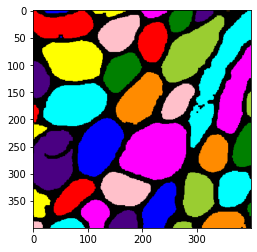

In [ ]:
#@markdown Set input and output folders.<br>
#@markdown Remember to set outputdir different from the pr_mask_dir, otherwise the predicted mask images will be overwritten by post-porcessed images.

pr_mask_dir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/ml_segmentation_test_1/pred"#@param {type:"string"}
outputdir = "/content/drive/MyDrive/chiaraZurzoloLab/CellWalker_iPythonNotebooks/for_CellWalker_paper/Flavia_axon_segmentation/ml_segmentation_test_1/pred_labeled_colored/"#@param {type:"string"}

pr_mask_filelist = sorted(os.listdir(pr_mask_dir))
fname = pr_mask_filelist[300]

# Read image as grayscale image (single channel)
img = cv2.imread(pr_mask_dir + "/" + fname, 0)
print("Processing", fname)
print("Image shape:", img.shape)

# Label image regions
img = label(img)

# Give random colors to the labels and convert to int between [0,255]
img = label2rgb(img, bg_label=0, bg_color=(0, 0, 0))
img = img*255
img = img.astype('int')

# Write RGB image
cv2.imwrite(outputdir + fname, img)

# Show labeled colored image
plt.imshow(img)